<a href="https://colab.research.google.com/github/fausto1364/age-estimation/blob/main/age_estimation_weighted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Age estimation using AlexNet based architecture with weighted loss function

In [ ]:
import os
import re
import csv
import numpy as np
import matplotlib.pyplot as plt
import uuid

# image manipulation
from PIL import Image

# deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

In [ ]:
# mount drive to access APPA-REAL
from google.colab import drive
drive.mount('/content/drive')

path='/content/drive/MyDrive/appa-real-release/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# just to store comands for Image...
'''image = Image.open(os.path.join(path,'005612.jpg_face.jpg'))
image.show()
print(image.format)
print(image.mode)
print(image.size)
test = image.resize((64,64))
test.show()'''

"image = Image.open(os.path.join(path,'005612.jpg_face.jpg'))\nimage.show()\nprint(image.format)\nprint(image.mode)\nprint(image.size)\ntest = image.resize((64,64))\ntest.show()"

In [ ]:
# extracts only face detected jpegs. Then rescales size of image and converts to numpy matrix
def preprocess(folder_path,size):
  X=[] # contains processed images
  y=[] # contains ids of images
  # regular expression pattern to only extract files with face detection
  pattern = r"\d+\.jpg_face\.jpg"

  # Loop over all files in the folder
  for imagename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, imagename)

    if re.match(pattern, imagename):
      image = Image.open(image_path)
      image = image.resize(size)
      array = [[np.float32(value) for value in row] for row in image.getdata()]
      X.append(np.array(array).reshape(image.size[1], image.size[0], 3))
      y.append(imagename.split(".")[0])
  return X,y

In [ ]:
# read the csv files with the apparent ages
def get_appaages(path):
  id = []
  appa_age = []

  # Read the CSV file
  with open(path, "r") as csv_file:
    csv_reader = csv.reader(csv_file)

    # Skip header
    next(csv_reader)

    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Append the values of the first and third columns to their respective lists
        id.append(row[0].split(".")[0])
        appa_age.append(row[2])

  return appa_age, id

In [ ]:
# allign two lists according to lists with ids
def allign_lists(A,a,B,b):
  X=[]
  Y=[]
  for i in range(len(A)):
    X.append(A[i])
    Y.append(np.float32(B[b.index(a[i])]))

  return np.array(X),np.array(Y)

In [ ]:
# extract and preprocess images
train_path = os.path.join(path, 'train/')
valid_path = os.path.join(path, 'valid/')
test_path = os.path.join(path, 'test/')

images_train,ids_train_im = preprocess(train_path,(64,64))
images_valid,ids_valid_im = preprocess(valid_path,(64,64))
images_test,ids_test_im = preprocess(test_path,(64,64))

# extract apparent ages
gt_train = os.path.join(path, 'gt_avg_train.csv')
gt_valid = os.path.join(path, 'gt_avg_valid.csv')
gt_test = os.path.join(path, 'gt_avg_test.csv')

appaages_train, ids_train_gt = get_appaages(gt_train)
appaages_valid, ids_valid_gt = get_appaages(gt_valid)
appaages_test, ids_test_gt = get_appaages(gt_test)

# sort apparent ages by images through the ids
images_train, appaages_train = allign_lists(images_train, ids_train_im, appaages_train, ids_train_gt)
images_valid, appaages_valid = allign_lists(images_valid, ids_valid_im, appaages_valid, ids_valid_gt)
images_test, appaages_test = allign_lists(images_test, ids_test_im, appaages_test, ids_test_gt)

In [ ]:
# calculate weights of train images to weight training
def weights(ages):
  A = np.ones(90) # initialize with ones to prevent problems in inversion
  for age in ages:
    A[round(age)] += 1
  # now we have the distribution of the ages. to get weights:

  for i in range(len(A)):
    A[i] = 1/A[i]

  return A*20

dist_train = weights(appaages_train)
print(dist_train)

[20.          0.35087719  0.36363636  0.86956522  0.40816327  0.40816327
  0.4         0.58823529  0.76923077  0.86956522  1.25        1.11111111
  1.42857143  1.33333333  1.11111111  0.64516129  0.37037037  0.24096386
  0.33898305  0.21978022  0.1459854   0.16666667  0.13605442  0.12048193
  0.10989011  0.11111111  0.12738854  0.12987013  0.13793103  0.13888889
  0.15503876  0.18018018  0.17241379  0.2020202   0.23255814  0.23809524
  0.23255814  0.21978022  0.26315789  0.30769231  0.33898305  0.37735849
  0.38461538  0.48780488  0.46511628  0.47619048  0.47619048  0.52631579
  0.60606061  0.58823529  0.64516129  0.55555556  0.38461538  0.52631579
  0.625       0.60606061  0.55555556  0.8         0.8         1.05263158
  0.8         0.95238095  1.81818182  1.05263158  2.85714286  1.53846154
  2.22222222  3.33333333  1.25        2.85714286  4.          3.33333333
  4.          2.85714286  5.          6.66666667  5.          6.66666667
 20.          5.          5.          6.66666667  6

In [ ]:
# Convert data to PyTorch tensors
train_data = data.TensorDataset(torch.tensor(images_train), torch.tensor(appaages_train))
test_data = data.TensorDataset(torch.tensor(images_test), torch.tensor(appaages_test))
valid_data = data.TensorDataset(torch.tensor(images_valid), torch.tensor(appaages_valid))

# Create dataloaders
batch_size = 32
train_dataloader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = data.DataLoader(test_data, batch_size=batch_size)
valid_dataloader = data.DataLoader(valid_data, batch_size=batch_size)

In [ ]:
class CNNmethods(nn.Module):
    def training_step(self, batch, dist_train):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = 0
        for i in range(len(labels)): # weighted MSE loss function
          loss += (dist_train[round(labels[i].item())] * (out[i] - labels[i]) ** 2)
        loss = loss / len(labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.mse_loss(out, labels)        # Calculate loss
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()    # Combine losses

        #batch_accs = [x['val_acc'] for x in outputs]
        #epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))

In [ ]:
# do the architecture. Basic, simple one
class AgeEstimation(CNNmethods):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

    self.relu = nn.ReLU()

    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.batchnorm1 = nn.BatchNorm2d(16)
    self.batchnorm2 = nn.BatchNorm2d(32)
    self.batchnorm3 = nn.BatchNorm2d(64)

    self.dropout1 = nn.Dropout(p=0.2)
    self.dropout2 = nn.Dropout(p=0.4)

    self.fc1 = nn.Linear(576, 1024)
    self.fc2 = nn.Linear(1024, 1)


  def forward(self, x):
    x = x.permute(0, 3, 1, 2)

    x = self.conv1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.batchnorm1(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.dropout1(x)
    x = self.batchnorm2(x)

    x = self.conv3(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.dropout1(x)
    x = self.batchnorm3(x)

    x = torch.flatten(x, 1)

    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)

    x = x.squeeze(1)

    return x

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, dist_train, opt_func = torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch, dist_train)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        #result['val_loss_MAE'] = evaluate_MAE(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [ ]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001
model = AgeEstimation()
torch.manual_seed(42)

# fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dataloader, valid_dataloader, dist_train, opt_func)

Epoch [0], train_loss: 269.8429, val_loss: 320.4278
Epoch [1], train_loss: 167.1353, val_loss: 355.1295
Epoch [2], train_loss: 151.5968, val_loss: 251.6102
Epoch [3], train_loss: 137.4053, val_loss: 498.3159
Epoch [4], train_loss: 122.7868, val_loss: 222.8654
Epoch [5], train_loss: 109.7453, val_loss: 224.4055
Epoch [6], train_loss: 109.1515, val_loss: 280.2693
Epoch [7], train_loss: 113.7517, val_loss: 236.5795
Epoch [8], train_loss: 100.4634, val_loss: 336.1136
Epoch [9], train_loss: 91.5156, val_loss: 216.6654
Epoch [10], train_loss: 82.7400, val_loss: 251.5844
Epoch [11], train_loss: 82.5707, val_loss: 205.0580
Epoch [12], train_loss: 80.3425, val_loss: 275.5641
Epoch [13], train_loss: 73.7408, val_loss: 199.5314
Epoch [14], train_loss: 68.5015, val_loss: 237.3293
Epoch [15], train_loss: 67.7924, val_loss: 227.4959
Epoch [16], train_loss: 64.0569, val_loss: 207.1207
Epoch [17], train_loss: 68.1037, val_loss: 227.3587
Epoch [18], train_loss: 62.1678, val_loss: 197.0396
Epoch [19], t

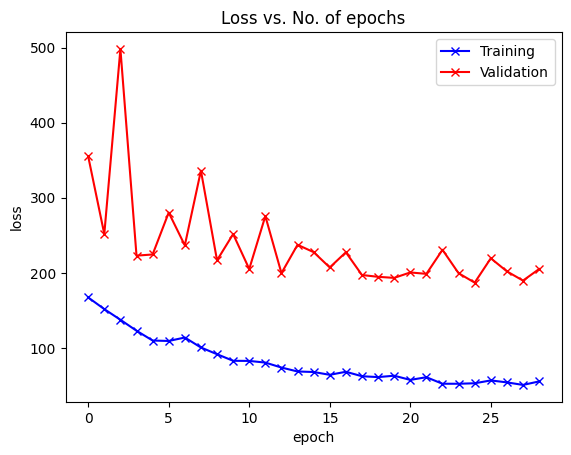

In [ ]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses[1:], '-bx') # leave out first as this will distort everything (no range defined)
    plt.plot(val_losses[1:], '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

More things to consider are these:

*   Check on the test set how the model performed
*   Calculate MAE (Mean Absolute Error) to compare to https://github.com/yu4u/age-gender-estimation/blob/master/README.md
*   How to make results reproducable

In [ ]:
def calculate_MAE_MSE(dataloader):
    # calculates MAE on test set
    model.eval()
    MAE=0
    count=0

    for images, labels in dataloader:
        with torch.no_grad():
            output = model(images)
            for i in range(len(labels)):
                MAE = MAE + abs(float(output[i])-float(labels[i]))
                count+=1


    MAE = MAE/count

    out_MAE = 'MAE: ' + str(MAE) + '; '

    # calculates MSE on test set
    model.eval()
    MSE=0
    count=0

    for images, labels in dataloader:
        with torch.no_grad():
            output = model(images)
            for i in range(len(labels)):
                MSE = MSE + (float(output[i])-float(labels[i]))**2
                count+=1


    MSE = MSE/count
    out_MSE = 'MSE: ' + str(MSE)
    return out_MAE+out_MSE

print('train: \n' + str(calculate_MAE_MSE(train_dataloader)))
print('valid: \n' + str(calculate_MAE_MSE(valid_dataloader)))
print('test: \n' + str(calculate_MAE_MSE(test_dataloader)))

train: 
MAE: 8.097158548589492; MSE: 109.51243710027232
valid: 
MAE: 10.923037273774545; MSE: 204.73527364076887
test: 
MAE: 11.859363764110121; MSE: 235.24615716434178


In [ ]:
# some weird problems with this architecture from (https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/)
'''class LeNet(nn.Module):
    def __init__(self, numChannels):
		    # call the parent constructor
		    super(LeNet, self).__init__()
		    # initialize first set of CONV => RELU => POOL layers
		    self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
		    self.relu1 = nn.ReLU()
		    self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		    # initialize second set of CONV => RELU => POOL layers
		    self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
		    self.relu2 = nn.ReLU()
		    self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		    # initialize first (and only) set of FC => RELU layers
		    self.fc1 = nn.Linear(in_features=800, out_features=500)
		    self.relu3 = nn.ReLU()
		    # initialize our softmax classifier
		    self.fc2 = nn.Linear(in_features=500, out_features=1)
		    self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
		    # pass the input through our first set of CONV => RELU =>
		    # POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = nn.flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		# pass the output to our softmax classifier to get our output
		# predictions
		x = self.fc2(x)
		output = self.logSoftmax(x)
		# return the output predictions
		return output'''